In [1]:
# Imports 
import jax.numpy as jnp
import matplotlib.pyplot as plt 

from jax import vmap
from jax import random

### Simulation state

The ***state*** of a simulation is composed of 4 elements:


- ***Simulator State***: This element contains general information about the simulator, such as the size of the environment, the maximum number of agents and objects, and other global settings that define the overall behavior of the simulation and ... parameters for the connection with clients if run in server mode.

- ***Agent State***: This element focuses on the agents in the simulation, which are primarily based on Braitenberg vehicles. It includes information about their behavior, wheel diameter, speed multipliers, maximum speed, and other agent-specific parameters that determine how they react to their environment and objects within it.

- ***Object State***: This element provides information about the objects present in the simulation. Currently, it mainly consists of the objects' color, but it can be expanded to include additional object-specific parameters as needed.

- ***Entity State***: This element combines information about both agents and objects, encompassing their physical parameters used in the physics simulation. It includes position, speed, mass, friction, and other relevant parameters. By grouping these parameters together, we can more easily compute and update the physical aspects of the simulation... (i.e update neighbors ... talk abt it) However, this structure might change in the future.


In the next cells, we'll explain step by step how to initialize a state.

<!-- All parameters used in a simulation

<div style="font-size: 80%;">

```yaml
agents:
  behavior: 1
  color: blue
  max_speed: 10.0
  prox_cos_min: 0.0
  prox_dist_max: 40.0
  speed_mul: 1.0
  theta_mul: 1.0
  wheel_diameter: 2.0

entities:
  agents_positions: null
  diameter: 5.0
  existing_agents: null
  existing_objects: null
  friction: 0.1
  mass_center: 1.0
  mass_orientation: 0.125
  objects_positions: null
  seed: 0

objects:
  color: red

simulator:
  box_size: 100.0
  collision_alpha: 0.5
  collision_eps: 0.1
  dt: 0.1
  freq: 40.0
  max_agents: 10
  max_objects: 2
  neighbor_radius: 100.0
  num_steps_lax: 4
  to_jit: true
  use_fori_loop: false


```

</div> -->

### Create simulator state

contains general info abt the simulator, n objects and agents ... but also parameters abt simulation running (use jit or not, use fori_loop, num steps per update loop ...) parameters abt sim speed and update freq for interface (dt, freq), parameters abt physics of the environment (collision_alpha, collision_eps)

In [2]:
from vivarium.simulator.states import SimulatorState

box_size = 100.
max_agents = 10
max_objects = 2
num_steps_lax = 4 # Rename this 
dt = 0.1
freq = 40.
neighbor_radius = 100.
to_jit = True
use_fori_loop = False
collision_alpha = 0.5
collision_eps = 0.1

simulator_state = SimulatorState(
    idx=jnp.array([0]),
    box_size=jnp.array([box_size]),              
    max_agents=jnp.array([max_agents]),
    max_objects=jnp.array([max_objects]),
    num_steps_lax=jnp.array([num_steps_lax], dtype=int),
    dt=jnp.array([dt], dtype=float),
    freq=jnp.array([freq], dtype=float),
    neighbor_radius=jnp.array([neighbor_radius], dtype=float),
    # Use 1*bool to transform True to 1 and False to 0
    to_jit= jnp.array([1*to_jit]),
    use_fori_loop=jnp.array([1*use_fori_loop]),
    collision_alpha=jnp.array([collision_alpha]),
    collision_eps=jnp.array([collision_eps]))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Create agents state

All information about the agents that are not shared by other entities  (not exactly with color)
 
Should maybe put entities state first ? 

In [3]:
from vivarium.simulator.states import AgentState

max_agents = 10
behavior = 1
wheel_diameter = 2.
speed_mul = 1.
max_speed = 10.
theta_mul = 1.
prox_dist_max = 40.
prox_cos_min = 0.
agents_color = jnp.array([0., 0., 1.])

agents_state = AgentState(
    nve_idx=jnp.arange(max_agents, dtype=int),
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=jnp.full((max_agents), behavior),
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    color=jnp.tile(agents_color, (max_agents, 1))
    )

### Create objects state

same for objects

In [4]:
from vivarium.simulator.states import ObjectState

max_objects = 2
objects_color = jnp.array([1., 0., 0.])

start_idx, stop_idx = max_agents, max_agents + max_objects
objects_nve_idx = jnp.arange(start_idx, stop_idx, dtype=int)

objects_state = ObjectState(
    nve_idx=objects_nve_idx,
    color=jnp.tile(objects_color, (max_objects, 1))
)

### Create entities state

contains all physical parameters (position, mass, momentum, friction ... about )

In [5]:
from vivarium.simulator.states import EntityState, EntityType
from jax_md.rigid_body import RigidBody

n_dims = 2 # 2D world
diameter = 5.
friction = 0.1
mass_center = 1.
mass_orientation = 0.125
existing_agents = 10
existing_objects = 2
seed = 0

n_entities = max_agents + max_objects

key = random.PRNGKey(seed)
key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

# Assign random positions to each entities
agents_positions = positions = random.uniform(key_agents_pos, (max_agents, n_dims)) * box_size
objects_positions = positions = random.uniform(key_objects_pos, (max_objects, n_dims)) * box_size
positions = jnp.concatenate((agents_positions, objects_positions))

# Assign random orientations between 0 and 2*pi
orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi

# Assign types to the entities
agents_entities = jnp.full(max_agents, EntityType.AGENT.value)
object_entities = jnp.full(max_objects, EntityType.OBJECT.value)
entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)

# Define arrays with existing entities
exists_agents = jnp.concatenate((jnp.ones((existing_agents)), jnp.zeros((max_agents - existing_agents))))
exists_objects = jnp.concatenate((jnp.ones((existing_objects)), jnp.zeros((max_objects - existing_objects))))
exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

# Use of rigid bodies from the jax_md lib to ... 
entity_state = EntityState(
    position=RigidBody(center=positions, orientation=orientations),
    momentum=None,
    force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
    mass=RigidBody(center=jnp.full((n_entities, 1), mass_center), orientation=jnp.full((n_entities), mass_orientation)),
    entity_type=entity_types,
    entity_idx = jnp.array(list(range(max_agents)) + list(range(max_objects))),
    diameter=jnp.full((n_entities), diameter),
    friction=jnp.full((n_entities), friction),
    exists=exists
    )


In [6]:

from vivarium.simulator.states import State

state = State(
        simulator_state=simulator_state,
        agent_state=agents_state,
        object_state=objects_state,
        entity_state=entity_state
    )

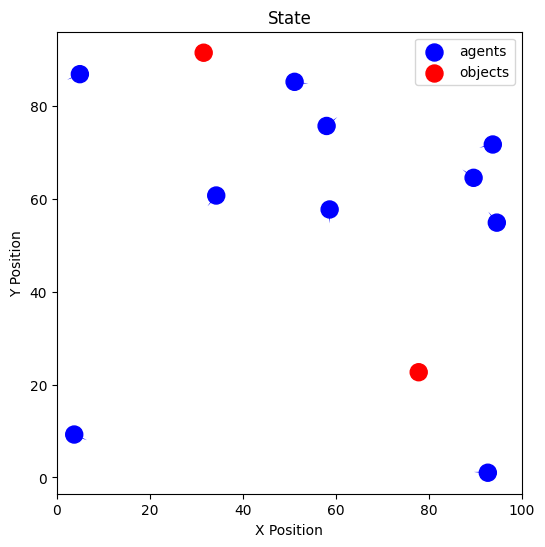

In [7]:


@vmap 
def normal(theta):
    return jnp.array([jnp.cos(theta), jnp.sin(theta)])

def render(entity_state):
    plt.figure(figsize=(6, 6))
    plt.xlim(0, box_size)
    plt.xlim(0, box_size)

    # Could replace this system to have agents and objects idx 
    agents_pos = entity_state.position.center[:max_agents]
    agents_theta = entity_state.position.orientation[:max_agents]
    agents_diameter = entity_state.diameter[:max_agents]
    objects_pos = entity_state.position.center[max_agents:]
    object_diameter = entity_state.diameter[max_agents:]

    x_agents, y_agents = agents_pos[:, 0], agents_pos[:, 1]
    x_objects, y_objects = objects_pos[:, 0], objects_pos[:, 1]
    n = normal(agents_theta)

    arrow_length = 3  # Length of the arrow
    size_scale = 30  # I do this bc I don't rly understand how s works with matplotlib scatter
    dx = arrow_length * n[:, 0]
    dy = arrow_length *  n[:, 1]
    plt.quiver(x_agents, y_agents, dx, dy, color='blue', scale=1, scale_units='xy', headwidth=0.8, angles='xy', width=0.01)
    plt.scatter(x_agents, y_agents, color='blue', s=agents_diameter*size_scale, label='agents')
    plt.scatter(x_objects, y_objects, color='red', s=object_diameter*size_scale, label='objects')

    plt.title('State')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()

    plt.show()

render(state.entity_state)

### Wrap the state inside a simulator

In [8]:
from vivarium.simulator import behaviors
from vivarium.simulator.simulator import Simulator
from vivarium.simulator.physics_engine import dynamics_rigid

simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)

You can also init a state with a yaml config file like this : 

<div style="font-size: 85%;">

```python
from vivarium.simulator.states import init_state

@hydra.main(version_base=None, config_path="../conf", config_name="config")
def main(cfg: DictConfig = None) -> None:

    args = OmegaConf.merge(cfg.default, cfg.scene)
    state = init_state(args)
    simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)
```
</div>

In [9]:
num_steps = 100
saving_name="notebook_tutorial"

# simulator.run(num_steps=num_steps, save=True, saving_name=saving_name)
state = simulator.state

### TODO 

- Add an option with lax.fori_loop ... 
- Add an option with scan 
- Show how to save ... 
- Need the thing to be faster cause boring atm

In [10]:
state_history = []

simulator.start_recording(saving_name)
assert simulator.recording

# Run the simulation for num_steps and save the nve_state
for _ in range(num_steps):
    simulator.step()
    state_history.append(simulator.state.entity_state)

simulator.stop_recording()

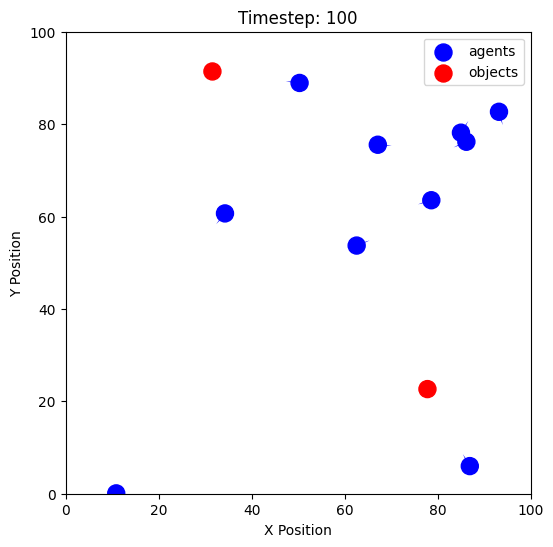

In [11]:
from IPython.display import display, clear_output
import time


def render_evolution(state_history, pause=0.001, skip_frames=1):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    for t in range(0, len(state_history), skip_frames):
        entity_state = state_history[t]
        agents_pos = entity_state.position.center[:max_agents]
        agents_theta = entity_state.position.orientation[:max_agents]
        agents_diameter = entity_state.diameter[:max_agents]
        objects_pos = entity_state.position.center[max_agents:]
        object_diameter = entity_state.diameter[max_agents:]

        x_agents, y_agents = agents_pos[:, 0], agents_pos[:, 1]
        x_objects, y_objects = objects_pos[:, 0], objects_pos[:, 1]
        n = normal(agents_theta)

        arrow_length = 3  
        size_scale = 30 
        dx = arrow_length * n[:, 0]
        dy = arrow_length *  n[:, 1]

        ax.clear()
        ax.set_xlim(0, box_size)
        ax.set_ylim(0, box_size)
        
        ax.quiver(x_agents, y_agents, dx, dy, color='blue', scale=1, scale_units='xy', headwidth=0.8, angles='xy', width=0.01)
        ax.scatter(x_agents, y_agents, color='blue', s=agents_diameter*size_scale, label='agents')
        ax.scatter(x_objects, y_objects, color='red', s=object_diameter*size_scale, label='objects')

        ax.set_title(f'Timestep: {t+1}')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.legend()
        
        display(fig)
        clear_output(wait=True)
        time.sleep(pause)

    plt.close(fig)

render_evolution(state_history)

In [12]:
state_history = simulator.load(saving_name)


--> Should also remove all the information about proximeters from physics engine (i.e physics engine only an util function to provide help for collisions ...). Think the best thing for an user would be to have a kind of file to define an environment (e.g EvoJax, JaxMARL) and import physics fn from physics engine (prox ... would be computed here). Can be wrapped with simulator (doesn't wrap a state but an env that can step ...) Then in the simulator use run fns ... that call this step.

--> Also something more general like obs for agents, in braitenberg case they are sensors (could be vision ... right ?)